In [2]:
import numpy as np
import yfinance as yf
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt

def BSM_options(ticker="AAPL", expiry=0, int_rate=0.05):
    stock = yf.Ticker(ticker)

    # Option chain for the selected expiry index
    opt_chain = stock.option_chain(stock.options[expiry])

    calls = opt_chain.calls.copy()
    puts  = opt_chain.puts.copy()

    # Spot price
    S = stock.info['regularMarketPrice']

    # Time to maturity (in years)
    expiration_date = datetime.strptime(stock.options[expiry], "%Y-%m-%d")
    today = datetime.now()
    T = (expiration_date - today).days / 365.0

    # Results storage
    call_prices = []
    put_prices  = []

    # ----- Calculate CALL theoretical prices -----
    for i, row in calls.iterrows():
        K = row['strike']
        sigma = row['impliedVolatility']

        d1 = (np.log(S / K) + (int_rate + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        C = S * norm.cdf(d1) - K * np.exp(-int_rate * T) * norm.cdf(d2)        # Call price
        call_prices.append(C)

    # ----- Calculate PUT theoretical prices -----
    for i, row in puts.iterrows():  # Loop through puts for put prices
        K = row['strike']
        sigma = row['impliedVolatility']

        d1 = (np.log(S / K) + (int_rate + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        P = K * np.exp(-int_rate * T) * norm.cdf(-d2) - S * norm.cdf(-d1)      # Put price
        put_prices.append(P)

    # Add theoretical prices to DataFrames
    calls['BSM_theoretical'] = call_prices
    puts['BSM_theoretical']  = put_prices

    # Comparison vs market price
    calls['BSM_vs_Market'] = calls['BSM_theoretical'] - calls['lastPrice']
    puts['BSM_vs_Market']  = puts['BSM_theoretical']  - puts['lastPrice']

    return {"calls": calls, "puts": puts}

In [ ]:
BSM_options(ticker="AAPL", expiry=0, int_rate=0.05)

{'calls':          contractSymbol             lastTradeDate  strike  lastPrice     bid  \
 0   AAPL251205C00110000 2025-11-26 18:52:56+00:00   110.0     168.32  166.35   
 1   AAPL251205C00120000 2025-11-05 16:30:23+00:00   120.0     150.51  156.10   
 2   AAPL251205C00130000 2025-11-05 16:31:41+00:00   130.0     140.54  146.10   
 3   AAPL251205C00140000 2025-11-05 16:30:23+00:00   140.0     130.59  135.80   
 4   AAPL251205C00150000 2025-11-18 19:10:17+00:00   150.0     119.14  126.55   
 ..                  ...                       ...     ...        ...     ...   
 63  AAPL251205C00375000 2025-11-12 18:24:13+00:00   375.0       0.01    0.00   
 64  AAPL251205C00380000 2025-10-31 16:40:34+00:00   380.0       0.04    0.00   
 65  AAPL251205C00385000 2025-11-06 18:54:09+00:00   385.0       0.01    0.00   
 66  AAPL251205C00390000 2025-11-24 19:42:50+00:00   390.0       0.01    0.00   
 67  AAPL251205C00400000 2025-11-28 14:30:06+00:00   400.0       0.01    0.00   
 
        ask  chan

In [3]:
result = BSM_options("AAPL", expiry=0)

print(result["calls"].head())   # theoretical call prices
print(result["puts"].head())    # theoretical put prices

        contractSymbol             lastTradeDate  strike  lastPrice     bid  \
0  AAPL251205C00110000 2025-11-26 18:52:56+00:00   110.0     168.32  166.35   
1  AAPL251205C00120000 2025-11-05 16:30:23+00:00   120.0     150.51  156.10   
2  AAPL251205C00130000 2025-11-05 16:31:41+00:00   130.0     140.54  146.10   
3  AAPL251205C00140000 2025-11-05 16:30:23+00:00   140.0     130.59  135.80   
4  AAPL251205C00150000 2025-11-18 19:10:17+00:00   150.0     119.14  126.55   

     ask  change  percentChange  volume  openInterest  impliedVolatility  \
0  168.6     0.0            0.0     3.0             7           0.000010   
1  158.9     0.0            0.0     NaN             1           2.210942   
2  148.9     0.0            0.0     NaN             0           2.015630   
3  137.9     0.0            0.0     NaN             1           0.000010   
4  127.9     0.0            0.0     1.0             3           0.000010   

   inTheMoney contractSize currency  BSM_theoretical  BSM_vs_Market 

In [5]:
def price_parameter_variability(K, r, t, s, sigma, option_type='call'):
    """
    Calculate BSM option price with proper error handling
    """
    # Handle edge cases
    if t <= 0:
        return max(s - K, 0) if option_type == 'call' else max(K - s, 0)

    if sigma <= 0:
        # If no volatility, return intrinsic value
        return max(s - K, 0) if option_type == 'call' else max(K - s, 0)

    try:
        # Calculate d1 and d2 - FIXED version
        d1 = (np.log(s / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)  # This is more stable than your original d2 calculation

        if option_type == 'call':
            price = s * norm.cdf(d1) - K * np.exp(-r * t) * norm.cdf(d2)
        else:  # put
            price = K * np.exp(-r * t) * norm.cdf(-d2) - s * norm.cdf(-d1)

        return max(price, 0)  # Option prices can't be negative

    except (ZeroDivisionError, FloatingPointError):
        # Fallback for numerical issues
        return max(s - K, 0) if option_type == 'call' else max(K - s, 0)

In [14]:
from ipywidgets import interact, FloatSlider, Checkbox
import matplotlib.pyplot as plt

def colab_interactive_analysis(ticker="AAPL", expiry=0):
    # Get your existing results
    results = BSM_options(ticker, expiry)
    calls_df = results['calls']
    puts_df = results['puts']

    # Extract what we need directly from the DataFrame and Yahoo
    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    # Get time to expiry
    expiration_date = datetime.strptime(stock.options[expiry], "%Y-%m-%d")
    today = datetime.now()
    T = (expiration_date - today).days / 365.0

    # Pick real options to analyze (ATM call and put)
    atm_call = calls_df.iloc[np.argmin(np.abs(calls_df['strike'] - S))]
    atm_put = puts_df.iloc[np.argmin(np.abs(puts_df['strike'] - S))]


    K_real = atm_call['strike']  # Same strike for call and put
    sigma_real_call = atm_call['impliedVolatility']
    sigma_real_put = atm_put['impliedVolatility']
    r = 0.05  # Default risk-free rate

    print(f"🎯 Analyzing REAL {ticker} ${K_real} Options")
    print(f"📊 Current: S=${S}, T={T:.2f}y")
    print(f"📈 Call IV: {sigma_real_call:.1%}, Put IV: {sigma_real_put:.1%}")

    @interact(
        spot_multiplier=FloatSlider(min=0.5, max=1.5, step=0.05, value=1.0,
                                  description='Spot Multiplier:'),
        call_volatility=FloatSlider(min=0.1, max=1.0, step=0.05, value=sigma_real_call,
                                  description='Call Volatility:'),
        put_volatility=FloatSlider(min=0.1, max=1.0, step=0.05, value=sigma_real_put,
                                 description='Put Volatility:'),
        time_years=FloatSlider(min=0.01, max=2.0, step=0.05, value=T,
                             description='Time (years):'),
        risk_free=FloatSlider(min=0.0, max=0.1, step=0.01, value=r,
                            description='Risk-Free Rate:'),
        show_calls=Checkbox(value=True, description='Show Calls'),
        show_puts=Checkbox(value=True, description='Show Puts')
    )
    def update_plot(spot_multiplier, call_volatility, put_volatility, time_years, risk_free, show_calls, show_puts):
        s_range = np.linspace(S * 0.5, S * 1.5, 100)

        plt.figure(figsize=(12, 8))

        if show_calls:
            call_prices = [price_parameter_variability(K_real, risk_free, time_years,
                                                     s * spot_multiplier, call_volatility, 'call')
                          for s in s_range]
            plt.plot(s_range, call_prices, 'g-', linewidth=2, label=f'Call Price')

        if show_puts:
            put_prices = [price_parameter_variability(K_real, risk_free, time_years,
                                                    s * spot_multiplier, put_volatility, 'put')
                         for s in s_range]
            plt.plot(s_range, put_prices, 'r-', linewidth=2, label=f'Put Price')

        plt.axvline(x=S * spot_multiplier, color='b', linestyle='--',
                   alpha=0.7, label=f'Spot: ${S * spot_multiplier:.2f}')
        plt.axvline(x=K_real, color='k', linestyle=':',
                   alpha=0.5, label=f'Strike: ${K_real}')

        plt.xlabel('Spot Price')
        plt.ylabel('Option Price')
        plt.title(f'Real {ticker} ${K_real} Options\n'
                 f'Call Vol: {call_volatility:.1%}, Put Vol: {put_volatility:.1%}, Time: {time_years:.2f}y')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Show current theoretical prices
        if show_calls:
            current_call_price = price_parameter_variability(K_real, risk_free, time_years,
                                                           S * spot_multiplier, call_volatility, 'call')
            print(f"📈 Call - Theoretical: ${current_call_price:.2f}, Market: ${atm_call['lastPrice']:.2f}")

        if show_puts:
            current_put_price = price_parameter_variability(K_real, risk_free, time_years,
                                                          S * spot_multiplier, put_volatility, 'put')
            print(f"📉 Put - Theoretical: ${current_put_price:.2f}, Market: ${atm_put['lastPrice']:.2f}")

# Run it
colab_interactive_analysis("AAPL", 0)

🎯 Analyzing REAL AAPL $280.0 Options
📊 Current: S=$278.85, T=0.01y
📈 Call IV: 18.6%, Put IV: 17.4%


interactive(children=(FloatSlider(value=1.0, description='Spot Multiplier:', max=1.5, min=0.5, step=0.05), Flo…

📊 Visualizing AAPL Options - Spot: $278.85, T: 0.01y


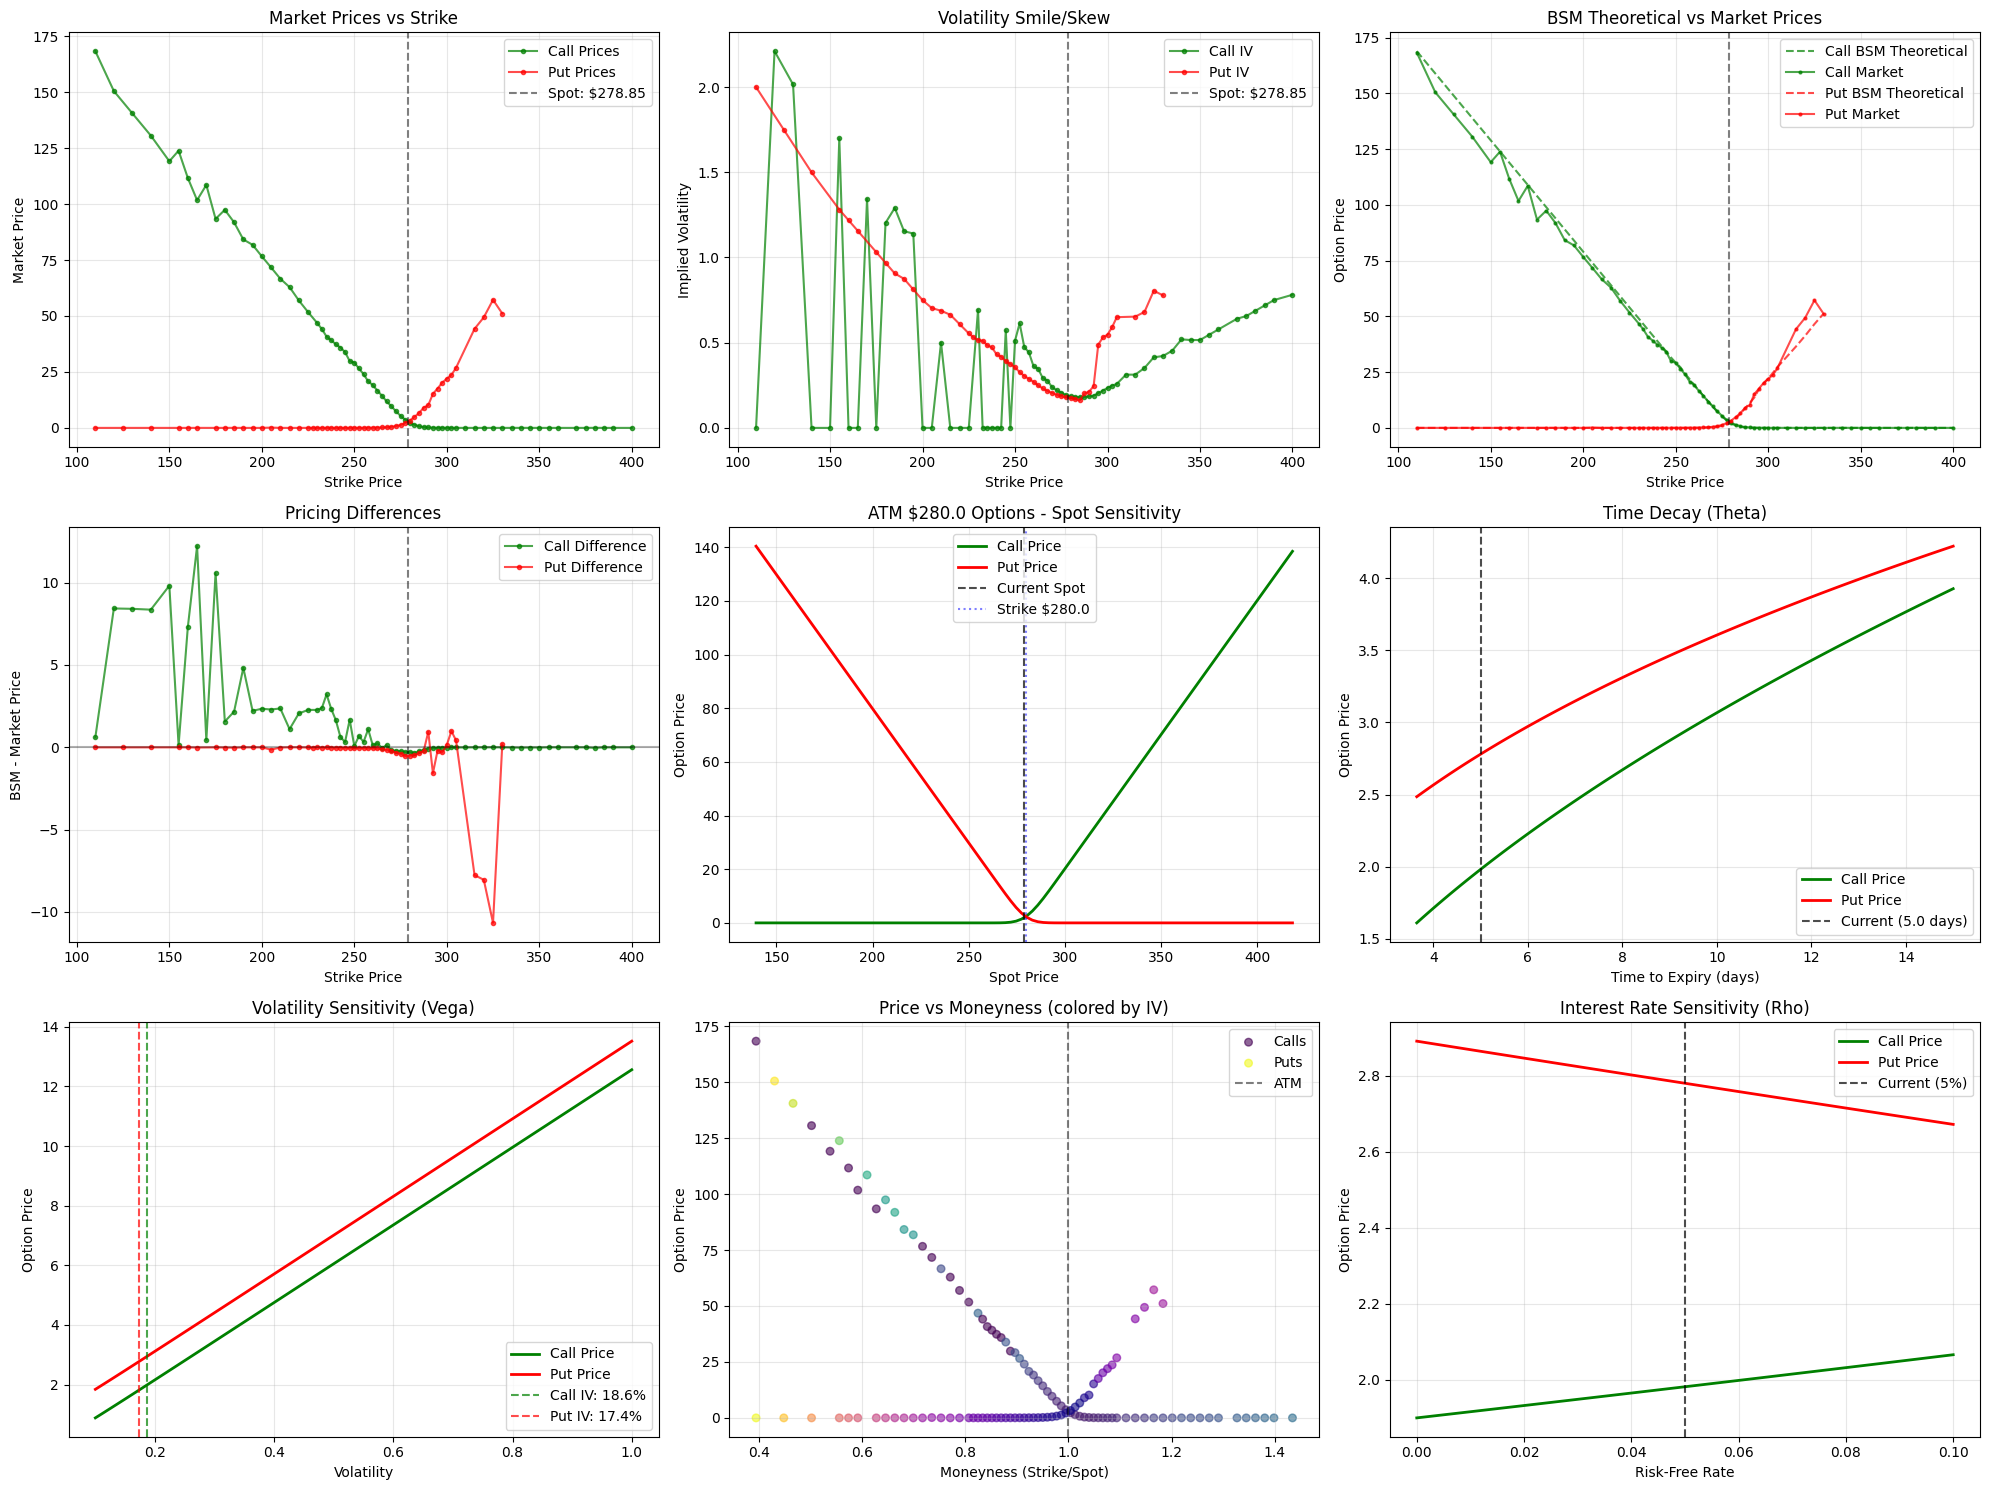


📈 SUMMARY STATISTICS:
Call Options - Count: 68, Min: $0.01, Max: $168.32, Avg IV: 43.3%
Put Options - Count: 53, Min: $0.01, Max: $57.23, Avg IV: 59.4%
ATM Call: $2.29, ATM Put: $3.30
BSM Mispricing - Calls: avg $1.53, Puts: avg $-0.57


In [7]:
import matplotlib.gridspec as gridspec  # Add this import at the top of your file

def visualize_option_prices(ticker="AAPL", expiry=0):
    """
    Comprehensive visualization of option prices across strikes and parameters
    """
    # Get option data
    results = BSM_options(ticker, expiry)
    calls_df = results['calls']
    puts_df = results['puts']

    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    # Get time to expiry
    expiration_date = datetime.strptime(stock.options[expiry], "%Y-%m-%d")
    today = datetime.now()
    T = (expiration_date - today).days / 365.0

    print(f"📊 Visualizing {ticker} Options - Spot: ${S:.2f}, T: {T:.2f}y")

    # Clean the data - remove rows with missing values
    calls_clean = calls_df.dropna(subset=['strike', 'lastPrice', 'impliedVolatility', 'BSM_theoretical'])
    puts_clean = puts_df.dropna(subset=['strike', 'lastPrice', 'impliedVolatility', 'BSM_theoretical'])

    # Ensure we have data to plot
    if len(calls_clean) == 0 or len(puts_clean) == 0:
        print("❌ No valid option data found after cleaning")
        return

    # Create a comprehensive figure
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(3, 3, figure=fig)  # Use gridspec.GridSpec instead of just GridSpec

    # Plot 1: Market Prices vs Strike (Volatility Smile)
    ax1 = fig.add_subplot(gs[0, 0])
    call_strikes = calls_clean['strike'].values
    put_strikes = puts_clean['strike'].values
    call_prices = calls_clean['lastPrice'].values
    put_prices = puts_clean['lastPrice'].values
    call_iv = calls_clean['impliedVolatility'].values
    put_iv = puts_clean['impliedVolatility'].values

    ax1.plot(call_strikes, call_prices, 'go-', markersize=3, label='Call Prices', alpha=0.7)
    ax1.plot(put_strikes, put_prices, 'ro-', markersize=3, label='Put Prices', alpha=0.7)
    ax1.axvline(x=S, color='black', linestyle='--', alpha=0.5, label=f'Spot: ${S:.2f}')
    ax1.set_xlabel('Strike Price')
    ax1.set_ylabel('Market Price')
    ax1.set_title('Market Prices vs Strike')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Implied Volatility Smile
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(call_strikes, call_iv, 'go-', markersize=3, label='Call IV', alpha=0.7)
    ax2.plot(put_strikes, put_iv, 'ro-', markersize=3, label='Put IV', alpha=0.7)
    ax2.axvline(x=S, color='black', linestyle='--', alpha=0.5, label=f'Spot: ${S:.2f}')
    ax2.set_xlabel('Strike Price')
    ax2.set_ylabel('Implied Volatility')
    ax2.set_title('Volatility Smile/Skew')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: BSM Theoretical vs Market Prices
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(call_strikes, calls_clean['BSM_theoretical'].values, 'g--', label='Call BSM Theoretical', alpha=0.7)
    ax3.plot(call_strikes, call_prices, 'go-', markersize=2, label='Call Market', alpha=0.7)
    ax3.plot(put_strikes, puts_clean['BSM_theoretical'].values, 'r--', label='Put BSM Theoretical', alpha=0.7)
    ax3.plot(put_strikes, put_prices, 'ro-', markersize=2, label='Put Market', alpha=0.7)
    ax3.axvline(x=S, color='black', linestyle='--', alpha=0.5)
    ax3.set_xlabel('Strike Price')
    ax3.set_ylabel('Option Price')
    ax3.set_title('BSM Theoretical vs Market Prices')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Price Difference (BSM - Market)
    ax4 = fig.add_subplot(gs[1, 0])
    call_diff = calls_clean['BSM_theoretical'] - calls_clean['lastPrice']
    put_diff = puts_clean['BSM_theoretical'] - puts_clean['lastPrice']

    ax4.plot(call_strikes, call_diff, 'go-', markersize=3, label='Call Difference', alpha=0.7)
    ax4.plot(put_strikes, put_diff, 'ro-', markersize=3, label='Put Difference', alpha=0.7)
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax4.axvline(x=S, color='black', linestyle='--', alpha=0.5)
    ax4.set_xlabel('Strike Price')
    ax4.set_ylabel('BSM - Market Price')
    ax4.set_title('Pricing Differences')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # Plot 5: Spot Price Sensitivity for ATM Options
    ax5 = fig.add_subplot(gs[1, 1])
    # Find the closest available strike to ATM
    atm_call_idx = np.argmin(np.abs(calls_clean['strike'] - S))
    atm_put_idx = np.argmin(np.abs(puts_clean['strike'] - S))

    atm_call = calls_clean.iloc[atm_call_idx]
    atm_put = puts_clean.iloc[atm_put_idx]

    K_atm = atm_call['strike']
    sigma_call = atm_call['impliedVolatility']
    sigma_put = atm_put['impliedVolatility']

    s_range = np.linspace(S * 0.5, S * 1.5, 100)
    call_prices_sensitivity = [price_parameter_variability(K_atm, 0.05, T, s, sigma_call, 'call')
                             for s in s_range]
    put_prices_sensitivity = [price_parameter_variability(K_atm, 0.05, T, s, sigma_put, 'put')
                            for s in s_range]

    ax5.plot(s_range, call_prices_sensitivity, 'g-', label='Call Price', linewidth=2)
    ax5.plot(s_range, put_prices_sensitivity, 'r-', label='Put Price', linewidth=2)
    ax5.axvline(x=S, color='black', linestyle='--', alpha=0.7, label=f'Current Spot')
    ax5.axvline(x=K_atm, color='blue', linestyle=':', alpha=0.5, label=f'Strike ${K_atm}')
    ax5.set_xlabel('Spot Price')
    ax5.set_ylabel('Option Price')
    ax5.set_title(f'ATM ${K_atm} Options - Spot Sensitivity')
    ax5.legend()
    ax5.grid(True, alpha=0.3)

    # Plot 6: Time Decay for ATM Options
    ax6 = fig.add_subplot(gs[1, 2])
    time_range = np.linspace(0.01, T * 3, 100)  # From very short to 3x current time
    call_time_decay = [price_parameter_variability(K_atm, 0.05, t, S, sigma_call, 'call')
                      for t in time_range]
    put_time_decay = [price_parameter_variability(K_atm, 0.05, t, S, sigma_put, 'put')
                     for t in time_range]

    ax6.plot(time_range * 365, call_time_decay, 'g-', label='Call Price', linewidth=2)
    ax6.plot(time_range * 365, put_time_decay, 'r-', label='Put Price', linewidth=2)
    ax6.axvline(x=T * 365, color='black', linestyle='--', alpha=0.7, label=f'Current ({T*365:.1f} days)')
    ax6.set_xlabel('Time to Expiry (days)')
    ax6.set_ylabel('Option Price')
    ax6.set_title('Time Decay (Theta)')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # Plot 7: Volatility Sensitivity
    ax7 = fig.add_subplot(gs[2, 0])
    vol_range = np.linspace(0.1, 1.0, 100)  # 10% to 100% volatility
    call_vol_sensitivity = [price_parameter_variability(K_atm, 0.05, T, S, vol, 'call')
                          for vol in vol_range]
    put_vol_sensitivity = [price_parameter_variability(K_atm, 0.05, T, S, vol, 'put')
                         for vol in vol_range]

    ax7.plot(vol_range, call_vol_sensitivity, 'g-', label='Call Price', linewidth=2)
    ax7.plot(vol_range, put_vol_sensitivity, 'r-', label='Put Price', linewidth=2)
    ax7.axvline(x=sigma_call, color='green', linestyle='--', alpha=0.7, label=f'Call IV: {sigma_call:.1%}')
    ax7.axvline(x=sigma_put, color='red', linestyle='--', alpha=0.7, label=f'Put IV: {sigma_put:.1%}')
    ax7.set_xlabel('Volatility')
    ax7.set_ylabel('Option Price')
    ax7.set_title('Volatility Sensitivity (Vega)')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # Plot 8: Moneyness Distribution
    ax8 = fig.add_subplot(gs[2, 1])
    call_moneyness = call_strikes / S
    put_moneyness = put_strikes / S

    scatter1 = ax8.scatter(call_moneyness, call_prices, c=call_iv, cmap='viridis', alpha=0.6,
               label='Calls', s=30)
    scatter2 = ax8.scatter(put_moneyness, put_prices, c=put_iv, cmap='plasma', alpha=0.6,
               label='Puts', s=30)
    ax8.axvline(x=1.0, color='black', linestyle='--', alpha=0.5, label='ATM')
    ax8.set_xlabel('Moneyness (Strike/Spot)')
    ax8.set_ylabel('Option Price')
    ax8.set_title('Price vs Moneyness (colored by IV)')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # Plot 9: Risk-Free Rate Sensitivity
    ax9 = fig.add_subplot(gs[2, 2])
    rate_range = np.linspace(0.0, 0.1, 100)  # 0% to 10% interest rates
    call_rate_sensitivity = [price_parameter_variability(K_atm, r, T, S, sigma_call, 'call')
                           for r in rate_range]
    put_rate_sensitivity = [price_parameter_variability(K_atm, r, T, S, sigma_put, 'put')
                          for r in rate_range]

    ax9.plot(rate_range, call_rate_sensitivity, 'g-', label='Call Price', linewidth=2)
    ax9.plot(rate_range, put_rate_sensitivity, 'r-', label='Put Price', linewidth=2)
    ax9.axvline(x=0.05, color='black', linestyle='--', alpha=0.7, label='Current (5%)')
    ax9.set_xlabel('Risk-Free Rate')
    ax9.set_ylabel('Option Price')
    ax9.set_title('Interest Rate Sensitivity (Rho)')
    ax9.legend()
    ax9.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print(f"\n📈 SUMMARY STATISTICS:")
    print(f"Call Options - Count: {len(calls_clean)}, Min: ${call_prices.min():.2f}, Max: ${call_prices.max():.2f}, Avg IV: {call_iv.mean():.1%}")
    print(f"Put Options - Count: {len(puts_clean)}, Min: ${put_prices.min():.2f}, Max: ${put_prices.max():.2f}, Avg IV: {put_iv.mean():.1%}")
    print(f"ATM Call: ${atm_call['lastPrice']:.2f}, ATM Put: ${atm_put['lastPrice']:.2f}")
    print(f"BSM Mispricing - Calls: avg ${call_diff.mean():.2f}, Puts: avg ${put_diff.mean():.2f}")

# Run the visualization
visualize_option_prices("AAPL", 0)

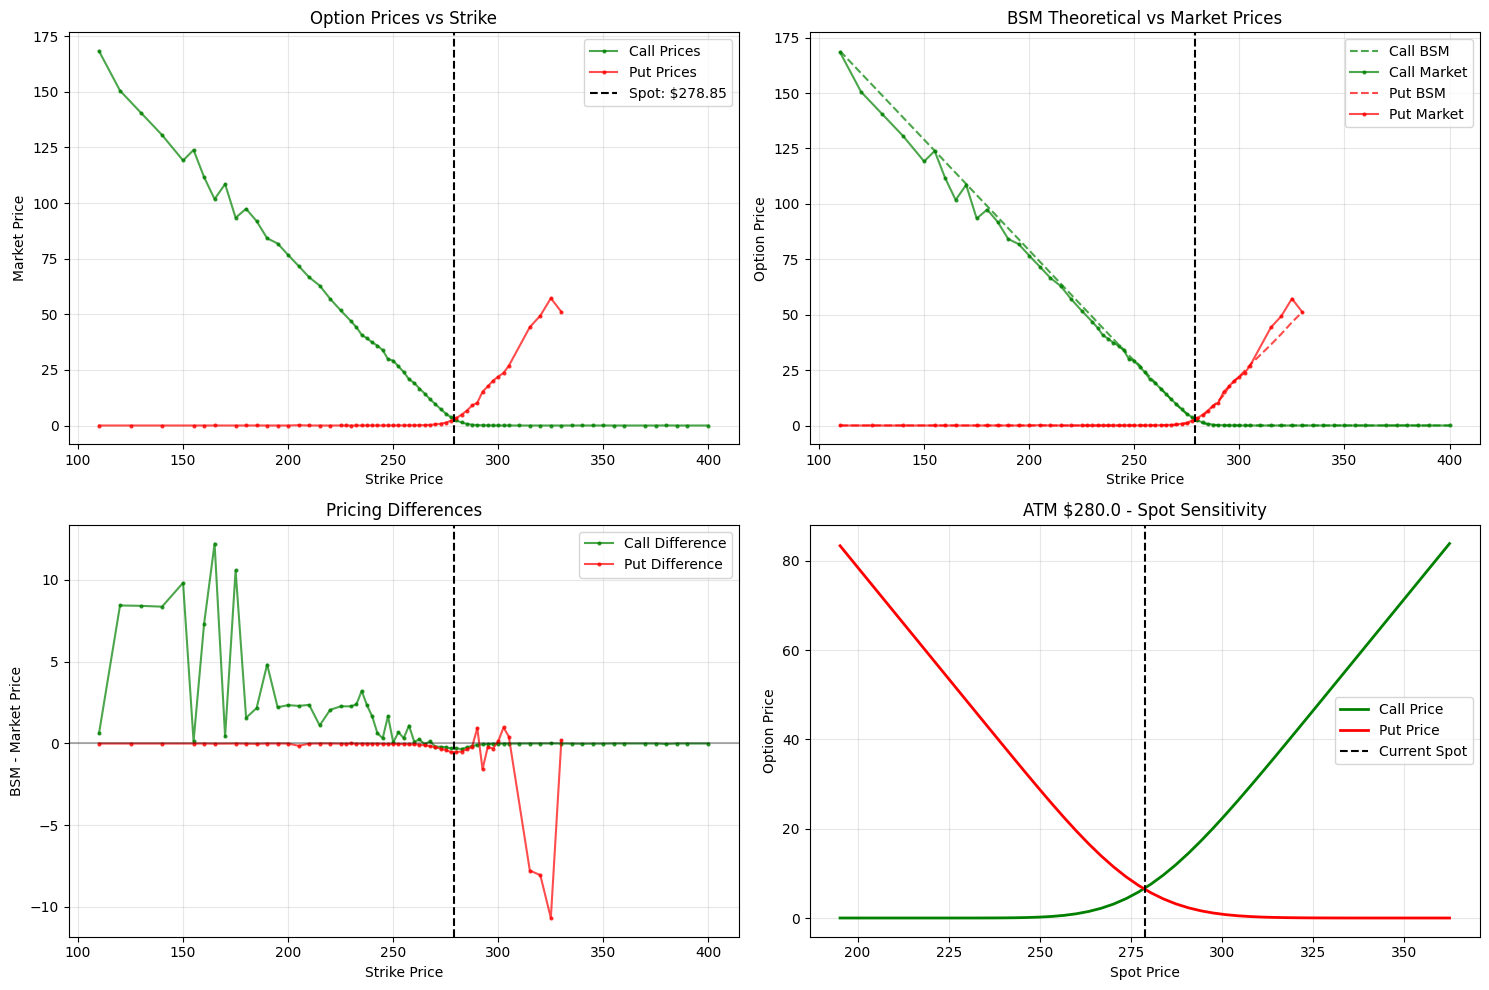


📊 Simple Summary for AAPL:
Spot Price: $278.85
ATM Call: $2.29
BSM Call: $1.98
Difference: $-0.31


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def simple_option_visualization(ticker="AAPL", expiry=0):
    """
    Simple visualization of option prices and BSM comparison
    """
    # Get option data
    results = BSM_options(ticker, expiry)
    calls_df = results['calls']
    puts_df = results['puts']

    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    # Clean data
    calls_clean = calls_df.dropna(subset=['strike', 'lastPrice', 'BSM_theoretical'])
    puts_clean = puts_df.dropna(subset=['strike', 'lastPrice', 'BSM_theoretical'])

    if len(calls_clean) == 0 or len(puts_clean) == 0:
        print("❌ No valid option data found")
        return

    # Create simple 2x2 plot
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Plot 1: Market Prices vs Strike
    ax1.plot(calls_clean['strike'], calls_clean['lastPrice'], 'go-', label='Call Prices', alpha=0.7, markersize=2)
    ax1.plot(puts_clean['strike'], puts_clean['lastPrice'], 'ro-', label='Put Prices', alpha=0.7, markersize=2)
    ax1.axvline(x=S, color='black', linestyle='--', label=f'Spot: ${S:.2f}')
    ax1.set_xlabel('Strike Price')
    ax1.set_ylabel('Market Price')
    ax1.set_title('Option Prices vs Strike')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: BSM Theoretical vs Market Prices
    ax2.plot(calls_clean['strike'], calls_clean['BSM_theoretical'], 'g--', label='Call BSM', alpha=0.7)
    ax2.plot(calls_clean['strike'], calls_clean['lastPrice'], 'go-', label='Call Market', alpha=0.7, markersize=2)
    ax2.plot(puts_clean['strike'], puts_clean['BSM_theoretical'], 'r--', label='Put BSM', alpha=0.7)
    ax2.plot(puts_clean['strike'], puts_clean['lastPrice'], 'ro-', label='Put Market', alpha=0.7, markersize=2)
    ax2.axvline(x=S, color='black', linestyle='--')
    ax2.set_xlabel('Strike Price')
    ax2.set_ylabel('Option Price')
    ax2.set_title('BSM Theoretical vs Market Prices')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Price Difference (BSM - Market)
    call_diff = calls_clean['BSM_theoretical'] - calls_clean['lastPrice']
    put_diff = puts_clean['BSM_theoretical'] - puts_clean['lastPrice']

    ax3.plot(calls_clean['strike'], call_diff, 'go-', label='Call Difference', alpha=0.7, markersize=2)
    ax3.plot(puts_clean['strike'], put_diff, 'ro-', label='Put Difference', alpha=0.7, markersize=2)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.axvline(x=S, color='black', linestyle='--')
    ax3.set_xlabel('Strike Price')
    ax3.set_ylabel('BSM - Market Price')
    ax3.set_title('Pricing Differences')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Simple Spot Price Sensitivity
    # Find ATM option
    atm_call_idx = np.argmin(np.abs(calls_clean['strike'] - S))
    atm_call = calls_clean.iloc[atm_call_idx]
    K_atm = atm_call['strike']
    sigma = atm_call['impliedVolatility']

    # Time to expiry (simplified)
    T = 0.1  # ~1 month

    # Spot price sensitivity
    s_range = np.linspace(S * 0.7, S * 1.3, 50)
    call_prices = [black_scholes(s, K_atm, T, 0.05, sigma, 'call') for s in s_range]
    put_prices = [black_scholes(s, K_atm, T, 0.05, sigma, 'put') for s in s_range]

    ax4.plot(s_range, call_prices, 'g-', label='Call Price', linewidth=2)
    ax4.plot(s_range, put_prices, 'r-', label='Put Price', linewidth=2)
    ax4.axvline(x=S, color='black', linestyle='--', label='Current Spot')
    ax4.set_xlabel('Spot Price')
    ax4.set_ylabel('Option Price')
    ax4.set_title(f'ATM ${K_atm} - Spot Sensitivity')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Simple summary
    print(f"\n📊 Simple Summary for {ticker}:")
    print(f"Spot Price: ${S:.2f}")
    print(f"ATM Call: ${atm_call['lastPrice']:.2f}")
    print(f"BSM Call: ${atm_call['BSM_theoretical']:.2f}")
    print(f"Difference: ${call_diff.iloc[atm_call_idx]:.2f}")

# Basic Black-Scholes function (you need this)
def black_scholes(S, K, T, r, sigma, option_type):
    from scipy.stats import norm
    if T <= 0:
        return max(S - K, 0) if option_type == 'call' else max(K - S, 0)

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # put
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Run it
simple_option_visualization("AAPL", 0)

📊 GREEKS VISUALIZATION
📊 Greeks Analysis - AAPL $280.0 Options
Spot: $278.85, Time: 0.01y, Call IV: 18.6%, Put IV: 17.4%

🎯 CURRENT GREEKS:
CALL: Delta: 0.442, Gamma: 0.0649, Theta: -0.2567/day, Vega: 0.1288, Rho: 0.0166
PUT:  Delta: -0.563, Gamma: 0.0694, Theta: -0.2018/day, Vega: 0.1286, Rho: -0.0219


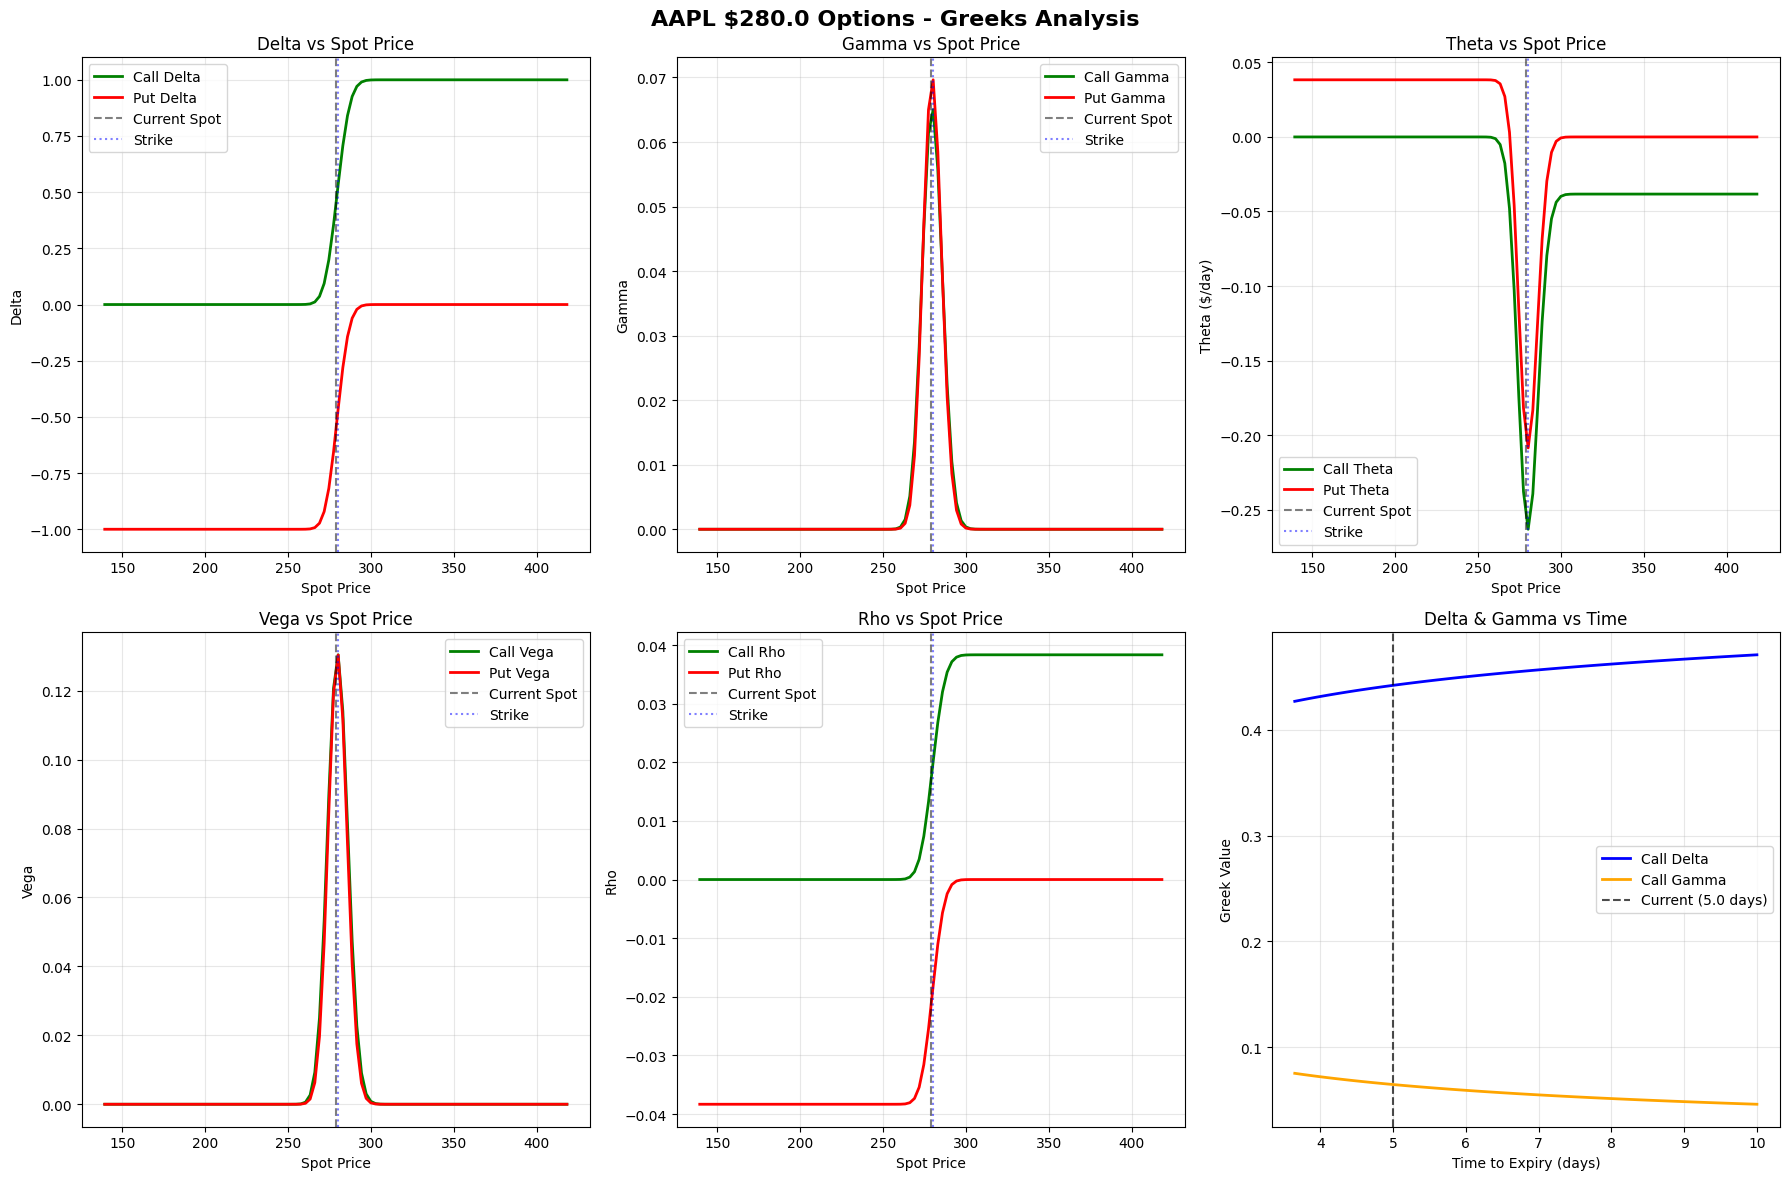


📊 GREEKS ACROSS STRIKES


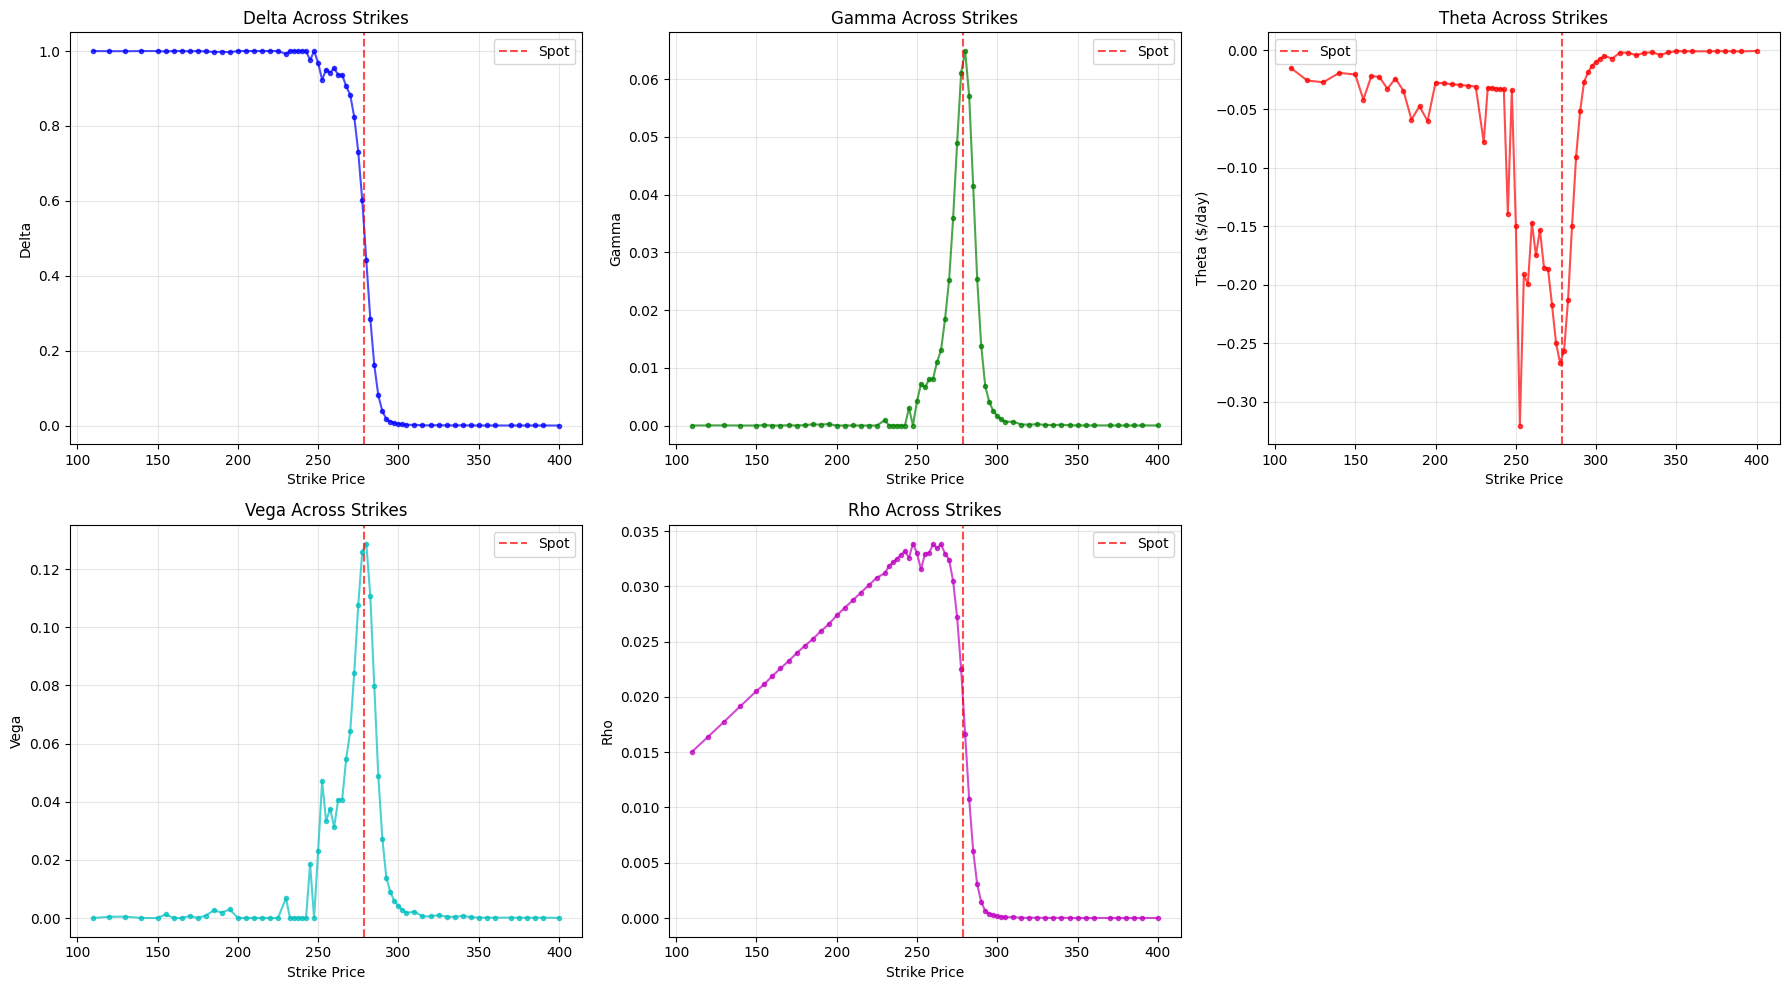

In [10]:
def calculate_greeks(K, r, t, s, sigma, option_type='call'):
    """
    Calculate all major Greeks for options
    Returns: delta, gamma, theta, vega, rho
    """
    # Handle edge cases
    if t <= 0 or sigma <= 0:
        if option_type == 'call':
            delta = 1.0 if s > K else 0.0
            return delta, 0.0, 0.0, 0.0, 0.0
        else:
            delta = -1.0 if s < K else 0.0
            return delta, 0.0, 0.0, 0.0, 0.0

    try:
        # Calculate d1 and d2
        d1 = (np.log(s / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)

        # Common calculations
        pdf_d1 = norm.pdf(d1)  # Probability density function at d1

        # DELTA
        if option_type == 'call':
            delta = norm.cdf(d1)
        else:  # put
            delta = norm.cdf(d1) - 1

        # GAMMA (same for calls and puts)
        gamma = pdf_d1 / (s * sigma * np.sqrt(t))

        # THETA
        if option_type == 'call':
            theta = (-(s * pdf_d1 * sigma) / (2 * np.sqrt(t))
                     - r * K * np.exp(-r * t) * norm.cdf(d2)) / 365  # Per day
        else:  # put
            theta = (-(s * pdf_d1 * sigma) / (2 * np.sqrt(t))
                     + r * K * np.exp(-r * t) * norm.cdf(-d2)) / 365  # Per day

        # VEGA (same for calls and puts)
        vega = (s * pdf_d1 * np.sqrt(t)) / 100  # Per 1% change in volatility

        # RHO
        if option_type == 'call':
            rho = (K * t * np.exp(-r * t) * norm.cdf(d2)) / 100  # Per 1% change in rates
        else:  # put
            rho = (-K * t * np.exp(-r * t) * norm.cdf(-d2)) / 100  # Per 1% change in rates

        return delta, gamma, theta, vega, rho

    except (ZeroDivisionError, FloatingPointError):
        return 0.0, 0.0, 0.0, 0.0, 0.0

def visualize_greeks(ticker="AAPL", expiry=0):
    """
    Visualize Greeks across different parameters
    """
    results = BSM_options(ticker, expiry)
    calls_df = results['calls']
    puts_df = results['puts']

    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    expiration_date = datetime.strptime(stock.options[expiry], "%Y-%m-%d")
    today = datetime.now()
    T = (expiration_date - today).days / 365.0

    # Pick ATM options
    atm_call = calls_df.iloc[np.argmin(np.abs(calls_df['strike'] - S))]
    atm_put = puts_df.iloc[np.argmin(np.abs(puts_df['strike'] - S))]

    K_atm = atm_call['strike']
    sigma_call = atm_call['impliedVolatility']
    sigma_put = atm_put['impliedVolatility']
    r = 0.05

    print(f"📊 Greeks Analysis - {ticker} ${K_atm} Options")
    print(f"Spot: ${S:.2f}, Time: {T:.2f}y, Call IV: {sigma_call:.1%}, Put IV: {sigma_put:.1%}")

    # Calculate current Greeks
    call_delta, call_gamma, call_theta, call_vega, call_rho = calculate_greeks(
        K_atm, r, T, S, sigma_call, 'call'
    )
    put_delta, put_gamma, put_theta, put_vega, put_rho = calculate_greeks(
        K_atm, r, T, S, sigma_put, 'put'
    )

    print(f"\n🎯 CURRENT GREEKS:")
    print(f"CALL: Delta: {call_delta:.3f}, Gamma: {call_gamma:.4f}, Theta: {call_theta:.4f}/day, Vega: {call_vega:.4f}, Rho: {call_rho:.4f}")
    print(f"PUT:  Delta: {put_delta:.3f}, Gamma: {put_gamma:.4f}, Theta: {put_theta:.4f}/day, Vega: {put_vega:.4f}, Rho: {put_rho:.4f}")

    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{ticker} ${K_atm} Options - Greeks Analysis', fontsize=16, fontweight='bold')

    # 1. DELTA vs Spot Price
    s_range = np.linspace(S * 0.5, S * 1.5, 100)
    call_deltas = [calculate_greeks(K_atm, r, T, s, sigma_call, 'call')[0] for s in s_range]
    put_deltas = [calculate_greeks(K_atm, r, T, s, sigma_put, 'put')[0] for s in s_range]

    axes[0,0].plot(s_range, call_deltas, 'g-', linewidth=2, label='Call Delta')
    axes[0,0].plot(s_range, put_deltas, 'r-', linewidth=2, label='Put Delta')
    axes[0,0].axvline(x=S, color='black', linestyle='--', alpha=0.5, label='Current Spot')
    axes[0,0].axvline(x=K_atm, color='blue', linestyle=':', alpha=0.5, label='Strike')
    axes[0,0].set_xlabel('Spot Price')
    axes[0,0].set_ylabel('Delta')
    axes[0,0].set_title('Delta vs Spot Price')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # 2. GAMMA vs Spot Price
    call_gammas = [calculate_greeks(K_atm, r, T, s, sigma_call, 'call')[1] for s in s_range]
    put_gammas = [calculate_greeks(K_atm, r, T, s, sigma_put, 'put')[1] for s in s_range]

    axes[0,1].plot(s_range, call_gammas, 'g-', linewidth=2, label='Call Gamma')
    axes[0,1].plot(s_range, put_gammas, 'r-', linewidth=2, label='Put Gamma')
    axes[0,1].axvline(x=S, color='black', linestyle='--', alpha=0.5, label='Current Spot')
    axes[0,1].axvline(x=K_atm, color='blue', linestyle=':', alpha=0.5, label='Strike')
    axes[0,1].set_xlabel('Spot Price')
    axes[0,1].set_ylabel('Gamma')
    axes[0,1].set_title('Gamma vs Spot Price')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # 3. THETA vs Spot Price
    call_thetas = [calculate_greeks(K_atm, r, T, s, sigma_call, 'call')[2] for s in s_range]
    put_thetas = [calculate_greeks(K_atm, r, T, s, sigma_put, 'put')[2] for s in s_range]

    axes[0,2].plot(s_range, call_thetas, 'g-', linewidth=2, label='Call Theta')
    axes[0,2].plot(s_range, put_thetas, 'r-', linewidth=2, label='Put Theta')
    axes[0,2].axvline(x=S, color='black', linestyle='--', alpha=0.5, label='Current Spot')
    axes[0,2].axvline(x=K_atm, color='blue', linestyle=':', alpha=0.5, label='Strike')
    axes[0,2].set_xlabel('Spot Price')
    axes[0,2].set_ylabel('Theta ($/day)')
    axes[0,2].set_title('Theta vs Spot Price')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # 4. VEGA vs Spot Price
    call_vegas = [calculate_greeks(K_atm, r, T, s, sigma_call, 'call')[3] for s in s_range]
    put_vegas = [calculate_greeks(K_atm, r, T, s, sigma_put, 'put')[3] for s in s_range]

    axes[1,0].plot(s_range, call_vegas, 'g-', linewidth=2, label='Call Vega')
    axes[1,0].plot(s_range, put_vegas, 'r-', linewidth=2, label='Put Vega')
    axes[1,0].axvline(x=S, color='black', linestyle='--', alpha=0.5, label='Current Spot')
    axes[1,0].axvline(x=K_atm, color='blue', linestyle=':', alpha=0.5, label='Strike')
    axes[1,0].set_xlabel('Spot Price')
    axes[1,0].set_ylabel('Vega')
    axes[1,0].set_title('Vega vs Spot Price')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # 5. RHO vs Spot Price
    call_rhos = [calculate_greeks(K_atm, r, T, s, sigma_call, 'call')[4] for s in s_range]
    put_rhos = [calculate_greeks(K_atm, r, T, s, sigma_put, 'put')[4] for s in s_range]

    axes[1,1].plot(s_range, call_rhos, 'g-', linewidth=2, label='Call Rho')
    axes[1,1].plot(s_range, put_rhos, 'r-', linewidth=2, label='Put Rho')
    axes[1,1].axvline(x=S, color='black', linestyle='--', alpha=0.5, label='Current Spot')
    axes[1,1].axvline(x=K_atm, color='blue', linestyle=':', alpha=0.5, label='Strike')
    axes[1,1].set_xlabel('Spot Price')
    axes[1,1].set_ylabel('Rho')
    axes[1,1].set_title('Rho vs Spot Price')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # 6. Time Decay of Greeks
    time_range = np.linspace(0.01, T * 2, 100)
    call_deltas_t = [calculate_greeks(K_atm, r, t, S, sigma_call, 'call')[0] for t in time_range]
    call_gammas_t = [calculate_greeks(K_atm, r, t, S, sigma_call, 'call')[1] for t in time_range]

    axes[1,2].plot(time_range * 365, call_deltas_t, 'b-', linewidth=2, label='Call Delta')
    axes[1,2].plot(time_range * 365, call_gammas_t, 'orange', linewidth=2, label='Call Gamma')
    axes[1,2].axvline(x=T * 365, color='black', linestyle='--', alpha=0.7, label=f'Current ({T*365:.1f} days)')
    axes[1,2].set_xlabel('Time to Expiry (days)')
    axes[1,2].set_ylabel('Greek Value')
    axes[1,2].set_title('Delta & Gamma vs Time')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'call_greeks': (call_delta, call_gamma, call_theta, call_vega, call_rho),
        'put_greeks': (put_delta, put_gamma, put_theta, put_vega, put_rho)
    }

def greeks_across_strikes(ticker="AAPL", expiry=0):
    """
    Show how Greeks vary across different strikes
    """
    results = BSM_options(ticker, expiry)
    calls_df = results['calls']

    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    expiration_date = datetime.strptime(stock.options[expiry], "%Y-%m-%d")
    today = datetime.now()
    T = (expiration_date - today).days / 365.0
    r = 0.05

    strikes = calls_df['strike'].values
    ivs = calls_df['impliedVolatility'].values

    # Calculate Greeks for each strike
    deltas, gammas, thetas, vegas, rhos = [], [], [], [], []

    for i, strike in enumerate(strikes):
        delta, gamma, theta, vega, rho = calculate_greeks(
            strike, r, T, S, ivs[i], 'call'
        )
        deltas.append(delta)
        gammas.append(gamma)
        thetas.append(theta)
        vegas.append(vega)
        rhos.append(rho)

    # Plot Greeks across strikes
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    axes[0,0].plot(strikes, deltas, 'bo-', markersize=3, alpha=0.7)
    axes[0,0].axvline(x=S, color='red', linestyle='--', alpha=0.7, label='Spot')
    axes[0,0].set_xlabel('Strike Price')
    axes[0,0].set_ylabel('Delta')
    axes[0,0].set_title('Delta Across Strikes')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].legend()

    axes[0,1].plot(strikes, gammas, 'go-', markersize=3, alpha=0.7)
    axes[0,1].axvline(x=S, color='red', linestyle='--', alpha=0.7, label='Spot')
    axes[0,1].set_xlabel('Strike Price')
    axes[0,1].set_ylabel('Gamma')
    axes[0,1].set_title('Gamma Across Strikes')
    axes[0,1].grid(True, alpha=0.3)
    axes[0,1].legend()

    axes[0,2].plot(strikes, thetas, 'ro-', markersize=3, alpha=0.7)
    axes[0,2].axvline(x=S, color='red', linestyle='--', alpha=0.7, label='Spot')
    axes[0,2].set_xlabel('Strike Price')
    axes[0,2].set_ylabel('Theta ($/day)')
    axes[0,2].set_title('Theta Across Strikes')
    axes[0,2].grid(True, alpha=0.3)
    axes[0,2].legend()

    axes[1,0].plot(strikes, vegas, 'co-', markersize=3, alpha=0.7)
    axes[1,0].axvline(x=S, color='red', linestyle='--', alpha=0.7, label='Spot')
    axes[1,0].set_xlabel('Strike Price')
    axes[1,0].set_ylabel('Vega')
    axes[1,0].set_title('Vega Across Strikes')
    axes[1,0].grid(True, alpha=0.3)
    axes[1,0].legend()

    axes[1,1].plot(strikes, rhos, 'mo-', markersize=3, alpha=0.7)
    axes[1,1].axvline(x=S, color='red', linestyle='--', alpha=0.7, label='Spot')
    axes[1,1].set_xlabel('Strike Price')
    axes[1,1].set_ylabel('Rho')
    axes[1,1].set_title('Rho Across Strikes')
    axes[1,1].grid(True, alpha=0.3)
    axes[1,1].legend()

    axes[1,2].axis('off')  # Empty subplot

    plt.tight_layout()
    plt.show()

# Run the Greek visualizations
print("📊 GREEKS VISUALIZATION")
greeks = visualize_greeks("AAPL", 0)

print("\n📊 GREEKS ACROSS STRIKES")
greeks_across_strikes("AAPL", 0)

In [11]:
def calculate_greeks_raw(K, r, t, s, sigma, option_type='call'):
    """
    Calculate all major Greeks for options - RAW VALUES
    Returns: delta, gamma, theta, vega, rho
    """
    # Handle edge cases
    if t <= 0 or sigma <= 0:
        if option_type == 'call':
            delta = 1.0 if s > K else 0.0
            return delta, 0.0, 0.0, 0.0, 0.0
        else:
            delta = -1.0 if s < K else 0.0
            return delta, 0.0, 0.0, 0.0, 0.0

    try:
        # Calculate d1 and d2
        d1 = (np.log(s / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)

        # Common calculations
        pdf_d1 = norm.pdf(d1)  # Probability density function at d1

        # DELTA - raw (sensitivity to $1 change in underlying)
        if option_type == 'call':
            delta = norm.cdf(d1)
        else:  # put
            delta = norm.cdf(d1) - 1

        # GAMMA - raw (sensitivity of delta to $1 change in underlying)
        gamma = pdf_d1 / (s * sigma * np.sqrt(t))

        # THETA - raw (sensitivity to 1 day time passage)
        if option_type == 'call':
            theta = (-(s * pdf_d1 * sigma) / (2 * np.sqrt(t))
                     - r * K * np.exp(-r * t) * norm.cdf(d2))
        else:  # put
            theta = (-(s * pdf_d1 * sigma) / (2 * np.sqrt(t))
                     + r * K * np.exp(-r * t) * norm.cdf(-d2))

        # VEGA - raw (sensitivity to 1.0 (100%) change in volatility)
        vega = s * pdf_d1 * np.sqrt(t)

        # RHO - raw (sensitivity to 1.0 (100%) change in interest rates)
        if option_type == 'call':
            rho = K * t * np.exp(-r * t) * norm.cdf(d2)
        else:  # put
            rho = -K * t * np.exp(-r * t) * norm.cdf(-d2)

        return delta, gamma, theta, vega, rho


        ###here were trying to fit all the greeks directly from the formula itself using only 2 packages that is numpy and stats

    except (ZeroDivisionError, FloatingPointError):
        return 0.0, 0.0, 0.0, 0.0, 0.0

def get_raw_greeks_for_options(ticker="AAPL", expiry=0):
    """
    Get raw Greeks for all options in the chain
    """
    results = BSM_options(ticker, expiry)
    calls_df = results['calls']
    puts_df = results['puts']

    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    expiration_date = datetime.strptime(stock.options[expiry], "%Y-%m-%d")
    today = datetime.now()
    T = (expiration_date - today).days / 365.0
    r = 0.05

    print(f"📊 RAW GREEKS - {ticker}")
    print(f"Spot: ${S:.2f}, Time: {T:.3f} years, Rate: {r:.1%}")
    print("-" * 80)

    # Calculate Greeks for calls
    calls_greeks = []
    for i, row in calls_df.iterrows():
        strike = row['strike']
        iv = row['impliedVolatility']

        delta, gamma, theta, vega, rho = calculate_greeks_raw(
            strike, r, T, S, iv, 'call'
        )

        calls_greeks.append({
            'strike': strike,
            'iv': iv,
            'delta': delta,
            'gamma': gamma,
            'theta': theta,
            'vega': vega,
            'rho': rho,
            'market_price': row['lastPrice']
        })

    # Calculate Greeks for puts
    puts_greeks = []
    for i, row in puts_df.iterrows():
        strike = row['strike']
        iv = row['impliedVolatility']

        delta, gamma, theta, vega, rho = calculate_greeks_raw(
            strike, r, T, S, iv, 'put'
        )

        puts_greeks.append({
            'strike': strike,
            'iv': iv,
            'delta': delta,
            'gamma': gamma,
            'theta': theta,
            'vega': vega,
            'rho': rho,
            'market_price': row['lastPrice']
        })

    return calls_greeks, puts_greeks

def display_raw_greeks_table(ticker="AAPL", expiry=0, num_options=10):
    """
    Display raw Greeks in a readable table format
    """
    calls_greeks, puts_greeks = get_raw_greeks_for_options(ticker, expiry)

    # Find ATM options
    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    # Sort by proximity to ATM
    calls_sorted = sorted(calls_greeks, key=lambda x: abs(x['strike'] - S))
    puts_sorted = sorted(puts_greeks, key=lambda x: abs(x['strike'] - S))

    print(f"\n🎯 CALLS - RAW GREEKS (Top {num_options} nearest ATM)")
    print("Strike  |   IV   |  Delta  |  Gamma  |  Theta/day |   Vega   |   Rho   | Market")
    print("-" * 85)
    for greek in calls_sorted[:num_options]:
        print(f"{greek['strike']:6.1f} | {greek['iv']:5.3f} | {greek['delta']:7.3f} | {greek['gamma']:7.4f} | "
              f"{greek['theta']:10.4f} | {greek['vega']:8.4f} | {greek['rho']:6.3f} | ${greek['market_price']:5.2f}")

    print(f"\n🎯 PUTS - RAW GREEKS (Top {num_options} nearest ATM)")
    print("Strike  |   IV   |  Delta  |  Gamma  |  Theta/day |   Vega   |   Rho   | Market")
    print("-" * 85)
    for greek in puts_sorted[:num_options]:
        print(f"{greek['strike']:6.1f} | {greek['iv']:5.3f} | {greek['delta']:7.3f} | {greek['gamma']:7.4f} | "
              f"{greek['theta']:10.4f} | {greek['vega']:8.4f} | {greek['rho']:6.3f} | ${greek['market_price']:5.2f}")

def analyze_specific_option(ticker="AAPL", expiry=0, strike=None, option_type='call'):
    """
    Get detailed raw Greeks for a specific option
    """
    calls_greeks, puts_greeks = get_raw_greeks_for_options(ticker, expiry)

    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    if strike is None:
        strike = S  # Default to ATM

    # Find the closest option to the specified strike
    if option_type == 'call':
        target_greeks = min(calls_greeks, key=lambda x: abs(x['strike'] - strike))
    else:
        target_greeks = min(puts_greeks, key=lambda x: abs(x['strike'] - strike))

    print(f"\n🔍 DETAILED RAW GREEKS - {ticker} ${target_greeks['strike']} {option_type.upper()}")
    print("=" * 60)
    print(f"Spot Price: ${S:.2f}")
    print(f"Strike: ${target_greeks['strike']:.2f}")
    print(f"Implied Volatility: {target_greeks['iv']:.3f} ({target_greeks['iv']*100:.1f}%)")
    print(f"Market Price: ${target_greeks['market_price']:.2f}")
    print("-" * 60)
    print(f"DELTA:    {target_greeks['delta']:.4f} (option price change per $1 change in underlying)")
    print(f"GAMMA:    {target_greeks['gamma']:.6f} (delta change per $1 change in underlying)")
    print(f"THETA:    {target_greeks['theta']:.4f} (price decay per 1 day)")
    print(f"VEGA:     {target_greeks['vega']:.4f} (price change per 1.0 (100%) vol change)")
    print(f"RHO:      {target_greeks['rho']:.4f} (price change per 1.0 (100%) rate change)")

    # Interpretation
    print("\n💡 INTERPRETATION:")
    if option_type == 'call':
        print(f"- Delta {target_greeks['delta']:.3f}: Option acts like {target_greeks['delta']*100:.1f}% of underlying")
    else:
        print(f"- Delta {target_greeks['delta']:.3f}: Option moves opposite to underlying")

    print(f"- Gamma {target_greeks['gamma']:.4f}: Delta changes by {target_greeks['gamma']:.4f} per $1 move")
    print(f"- Theta {target_greeks['theta']:.4f}: Loses ${abs(target_greeks['theta']):.4f} per day from time decay")
    print(f"- Vega {target_greeks['vega']:.4f}: Gains ${target_greeks['vega']:.4f} if vol increases 100%")
    print(f"- Rho {target_greeks['rho']:.4f}: {'Gains' if target_greeks['rho'] > 0 else 'Loses'} ${abs(target_greeks['rho']):.4f} if rates increase 100%")

# Run the raw Greek analysis
print("📊 RAW GREEKS ANALYSIS")
calls_greeks, puts_greeks = get_raw_greeks_for_options("AAPL", 0)

print("\n📋 RAW GREEKS TABLE")
display_raw_greeks_table("AAPL", 0, 8)

print("\n🔍 SPECIFIC OPTION ANALYSIS")
analyze_specific_option("AAPL", 0, strike=180, option_type='call')  # Change strike as needed
analyze_specific_option("AAPL", 0, strike=180, option_type='put')   # Change strike as needed

📊 RAW GREEKS ANALYSIS
📊 RAW GREEKS - AAPL
Spot: $278.85, Time: 0.014 years, Rate: 5.0%
--------------------------------------------------------------------------------

📋 RAW GREEKS TABLE
📊 RAW GREEKS - AAPL
Spot: $278.85, Time: 0.014 years, Rate: 5.0%
--------------------------------------------------------------------------------

🎯 CALLS - RAW GREEKS (Top 8 nearest ATM)
Strike  |   IV   |  Delta  |  Gamma  |  Theta/day |   Vega   |   Rho   | Market
-------------------------------------------------------------------------------------
 280.0 | 0.186 |   0.442 |  0.0649 |   -93.7067 |  12.8816 |  1.661 | $ 2.29
 277.5 | 0.194 |   0.601 |  0.0611 |   -97.2623 |  12.6014 |  2.249 | $ 3.66
 282.5 | 0.182 |   0.286 |  0.0571 |   -77.7555 |  11.0902 |  1.076 | $ 1.39
 275.0 | 0.206 |   0.731 |  0.0490 |   -91.0901 |  10.7710 |  2.722 | $ 5.40
 285.0 | 0.180 |   0.161 |  0.0415 |   -54.5999 |   7.9650 |  0.607 | $ 0.74
 272.5 | 0.221 |   0.824 |  0.0359 |   -79.1881 |   8.4439 |  3.048 | $ 7

In [12]:
def calculate_greeks_raw(K, r, t, s, sigma, option_type='call'):
    """
    Calculate all major Greeks for options - RAW VALUES
    Returns: delta, gamma, theta, vega, rho
    """
    # Handle edge cases
    if t <= 0 or sigma <= 0:
        if option_type == 'call':
            delta = 1.0 if s > K else 0.0
            return delta, 0.0, 0.0, 0.0, 0.0
        else:
            delta = -1.0 if s < K else 0.0
            return delta, 0.0, 0.0, 0.0, 0.0

    try:
        # Calculate d1 and d2
        d1 = (np.log(s / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)

        # Common calculations
        pdf_d1 = norm.pdf(d1)  # Probability density function at d1

        # DELTA - raw (sensitivity to $1 change in underlying)
        if option_type == 'call':
            delta = norm.cdf(d1)
        else:  # put
            delta = norm.cdf(d1) - 1

        # GAMMA - raw (sensitivity of delta to $1 change in underlying)
        gamma = pdf_d1 / (s * sigma * np.sqrt(t))

        # THETA - raw (sensitivity to 1 day time passage)
        if option_type == 'call':
            theta = (-(s * pdf_d1 * sigma) / (2 * np.sqrt(t))
                     - r * K * np.exp(-r * t) * norm.cdf(d2))
        else:  # put
            theta = (-(s * pdf_d1 * sigma) / (2 * np.sqrt(t))
                     + r * K * np.exp(-r * t) * norm.cdf(-d2))

        # VEGA - raw (sensitivity to 1.0 (100%) change in volatility)
        vega = s * pdf_d1 * np.sqrt(t)

        # RHO - raw (sensitivity to 1.0 (100%) change in interest rates)
        if option_type == 'call':
            rho = K * t * np.exp(-r * t) * norm.cdf(d2)
        else:  # put
            rho = -K * t * np.exp(-r * t) * norm.cdf(-d2)

        return delta, gamma, theta, vega, rho

    except (ZeroDivisionError, FloatingPointError):
        return 0.0, 0.0, 0.0, 0.0, 0.0

def get_raw_greeks_for_options(ticker="AAPL", expiry=0):
    """
    Get raw Greeks for all options in the chain
    """
    results = BSM_options(ticker, expiry)
    calls_df = results['calls']
    puts_df = results['puts']

    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    expiration_date = datetime.strptime(stock.options[expiry], "%Y-%m-%d")
    today = datetime.now()
    T = (expiration_date - today).days / 365.0
    r = 0.05

    print(f"📊 RAW GREEKS - {ticker}")
    print(f"Spot: ${S:.2f}, Time: {T:.3f} years, Rate: {r:.1%}")
    print("-" * 80)

    # Calculate Greeks for calls
    calls_greeks = []
    for i, row in calls_df.iterrows():
        strike = row['strike']
        iv = row['impliedVolatility']

        delta, gamma, theta, vega, rho = calculate_greeks_raw(
            strike, r, T, S, iv, 'call'
        )

        calls_greeks.append({
            'strike': strike,
            'iv': iv,
            'delta': delta,
            'gamma': gamma,
            'theta': theta,
            'vega': vega,
            'rho': rho,
            'market_price': row['lastPrice']
        })

    # Calculate Greeks for puts
    puts_greeks = []
    for i, row in puts_df.iterrows():
        strike = row['strike']
        iv = row['impliedVolatility']

        delta, gamma, theta, vega, rho = calculate_greeks_raw(
            strike, r, T, S, iv, 'put'
        )

        puts_greeks.append({
            'strike': strike,
            'iv': iv,
            'delta': delta,
            'gamma': gamma,
            'theta': theta,
            'vega': vega,
            'rho': rho,
            'market_price': row['lastPrice']
        })

    return calls_greeks, puts_greeks

def display_raw_greeks_table(ticker="AAPL", expiry=0, num_options=10):
    """
    Display raw Greeks in a readable table format
    """
    calls_greeks, puts_greeks = get_raw_greeks_for_options(ticker, expiry)

    # Find ATM options
    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    # Sort by proximity to ATM
    calls_sorted = sorted(calls_greeks, key=lambda x: abs(x['strike'] - S))
    puts_sorted = sorted(puts_greeks, key=lambda x: abs(x['strike'] - S))

    print(f"\n🎯 CALLS - RAW GREEKS (Top {num_options} nearest ATM)")
    print("Strike  |   IV   |  Delta  |  Gamma  |  Theta/day |   Vega   |   Rho   | Market")
    print("-" * 85)
    for greek in calls_sorted[:num_options]:
        print(f"{greek['strike']:6.1f} | {greek['iv']:5.3f} | {greek['delta']:7.3f} | {greek['gamma']:7.4f} | "
              f"{greek['theta']:10.4f} | {greek['vega']:8.4f} | {greek['rho']:6.3f} | ${greek['market_price']:5.2f}")

    print(f"\n🎯 PUTS - RAW GREEKS (Top {num_options} nearest ATM)")
    print("Strike  |   IV   |  Delta  |  Gamma  |  Theta/day |   Vega   |   Rho   | Market")
    print("-" * 85)
    for greek in puts_sorted[:num_options]:
        print(f"{greek['strike']:6.1f} | {greek['iv']:5.3f} | {greek['delta']:7.3f} | {greek['gamma']:7.4f} | "
              f"{greek['theta']:10.4f} | {greek['vega']:8.4f} | {greek['rho']:6.3f} | ${greek['market_price']:5.2f}")

def analyze_specific_option(ticker="AAPL", expiry=0, strike=None, option_type='call'):
    """
    Get detailed raw Greeks for a specific option
    """
    calls_greeks, puts_greeks = get_raw_greeks_for_options(ticker, expiry)

    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    if strike is None:
        strike = S  # Default to ATM

    # Find the closest option to the specified strike
    if option_type == 'call':
        target_greeks = min(calls_greeks, key=lambda x: abs(x['strike'] - strike))
    else:
        target_greeks = min(puts_greeks, key=lambda x: abs(x['strike'] - strike))

    print(f"\n🔍 DETAILED RAW GREEKS - {ticker} ${target_greeks['strike']} {option_type.upper()}")
    print("=" * 60)
    print(f"Spot Price: ${S:.2f}")
    print(f"Strike: ${target_greeks['strike']:.2f}")
    print(f"Implied Volatility: {target_greeks['iv']:.3f} ({target_greeks['iv']*100:.1f}%)")
    print(f"Market Price: ${target_greeks['market_price']:.2f}")
    print("-" * 60)
    print(f"DELTA:    {target_greeks['delta']:.4f} (option price change per $1 change in underlying)")
    print(f"GAMMA:    {target_greeks['gamma']:.6f} (delta change per $1 change in underlying)")
    print(f"THETA:    {target_greeks['theta']:.4f} (price decay per 1 day)")
    print(f"VEGA:     {target_greeks['vega']:.4f} (price change per 1.0 (100%) vol change)")
    print(f"RHO:      {target_greeks['rho']:.4f} (price change per 1.0 (100%) rate change)")

    # Interpretation
    print("\n💡 INTERPRETATION:")
    if option_type == 'call':
        print(f"- Delta {target_greeks['delta']:.3f}: Option acts like {target_greeks['delta']*100:.1f}% of underlying")
    else:
        print(f"- Delta {target_greeks['delta']:.3f}: Option moves opposite to underlying")

    print(f"- Gamma {target_greeks['gamma']:.4f}: Delta changes by {target_greeks['gamma']:.4f} per $1 move")
    print(f"- Theta {target_greeks['theta']:.4f}: Loses ${abs(target_greeks['theta']):.4f} per day from time decay")
    print(f"- Vega {target_greeks['vega']:.4f}: Gains ${target_greeks['vega']:.4f} if vol increases 100%")
    print(f"- Rho {target_greeks['rho']:.4f}: {'Gains' if target_greeks['rho'] > 0 else 'Loses'} ${abs(target_greeks['rho']):.4f} if rates increase 100%")

# Run the raw Greek analysis
print("📊 RAW GREEKS ANALYSIS")
calls_greeks, puts_greeks = get_raw_greeks_for_options("AAPL", 0)

print("\n📋 RAW GREEKS TABLE")
display_raw_greeks_table("AAPL", 0, 8)

print("\n🔍 SPECIFIC OPTION ANALYSIS")
analyze_specific_option("AAPL", 0, strike=180, option_type='call')  # Change strike as needed
analyze_specific_option("AAPL", 0, strike=180, option_type='put')   # Change strike as needed

📊 RAW GREEKS ANALYSIS
📊 RAW GREEKS - AAPL
Spot: $278.85, Time: 0.014 years, Rate: 5.0%
--------------------------------------------------------------------------------

📋 RAW GREEKS TABLE
📊 RAW GREEKS - AAPL
Spot: $278.85, Time: 0.014 years, Rate: 5.0%
--------------------------------------------------------------------------------

🎯 CALLS - RAW GREEKS (Top 8 nearest ATM)
Strike  |   IV   |  Delta  |  Gamma  |  Theta/day |   Vega   |   Rho   | Market
-------------------------------------------------------------------------------------
 280.0 | 0.186 |   0.442 |  0.0649 |   -93.7067 |  12.8816 |  1.661 | $ 2.29
 277.5 | 0.194 |   0.601 |  0.0611 |   -97.2623 |  12.6014 |  2.249 | $ 3.66
 282.5 | 0.182 |   0.286 |  0.0571 |   -77.7555 |  11.0902 |  1.076 | $ 1.39
 275.0 | 0.206 |   0.731 |  0.0490 |   -91.0901 |  10.7710 |  2.722 | $ 5.40
 285.0 | 0.180 |   0.161 |  0.0415 |   -54.5999 |   7.9650 |  0.607 | $ 0.74
 272.5 | 0.221 |   0.824 |  0.0359 |   -79.1881 |   8.4439 |  3.048 | $ 7

📊 Analyzing 41 common strikes


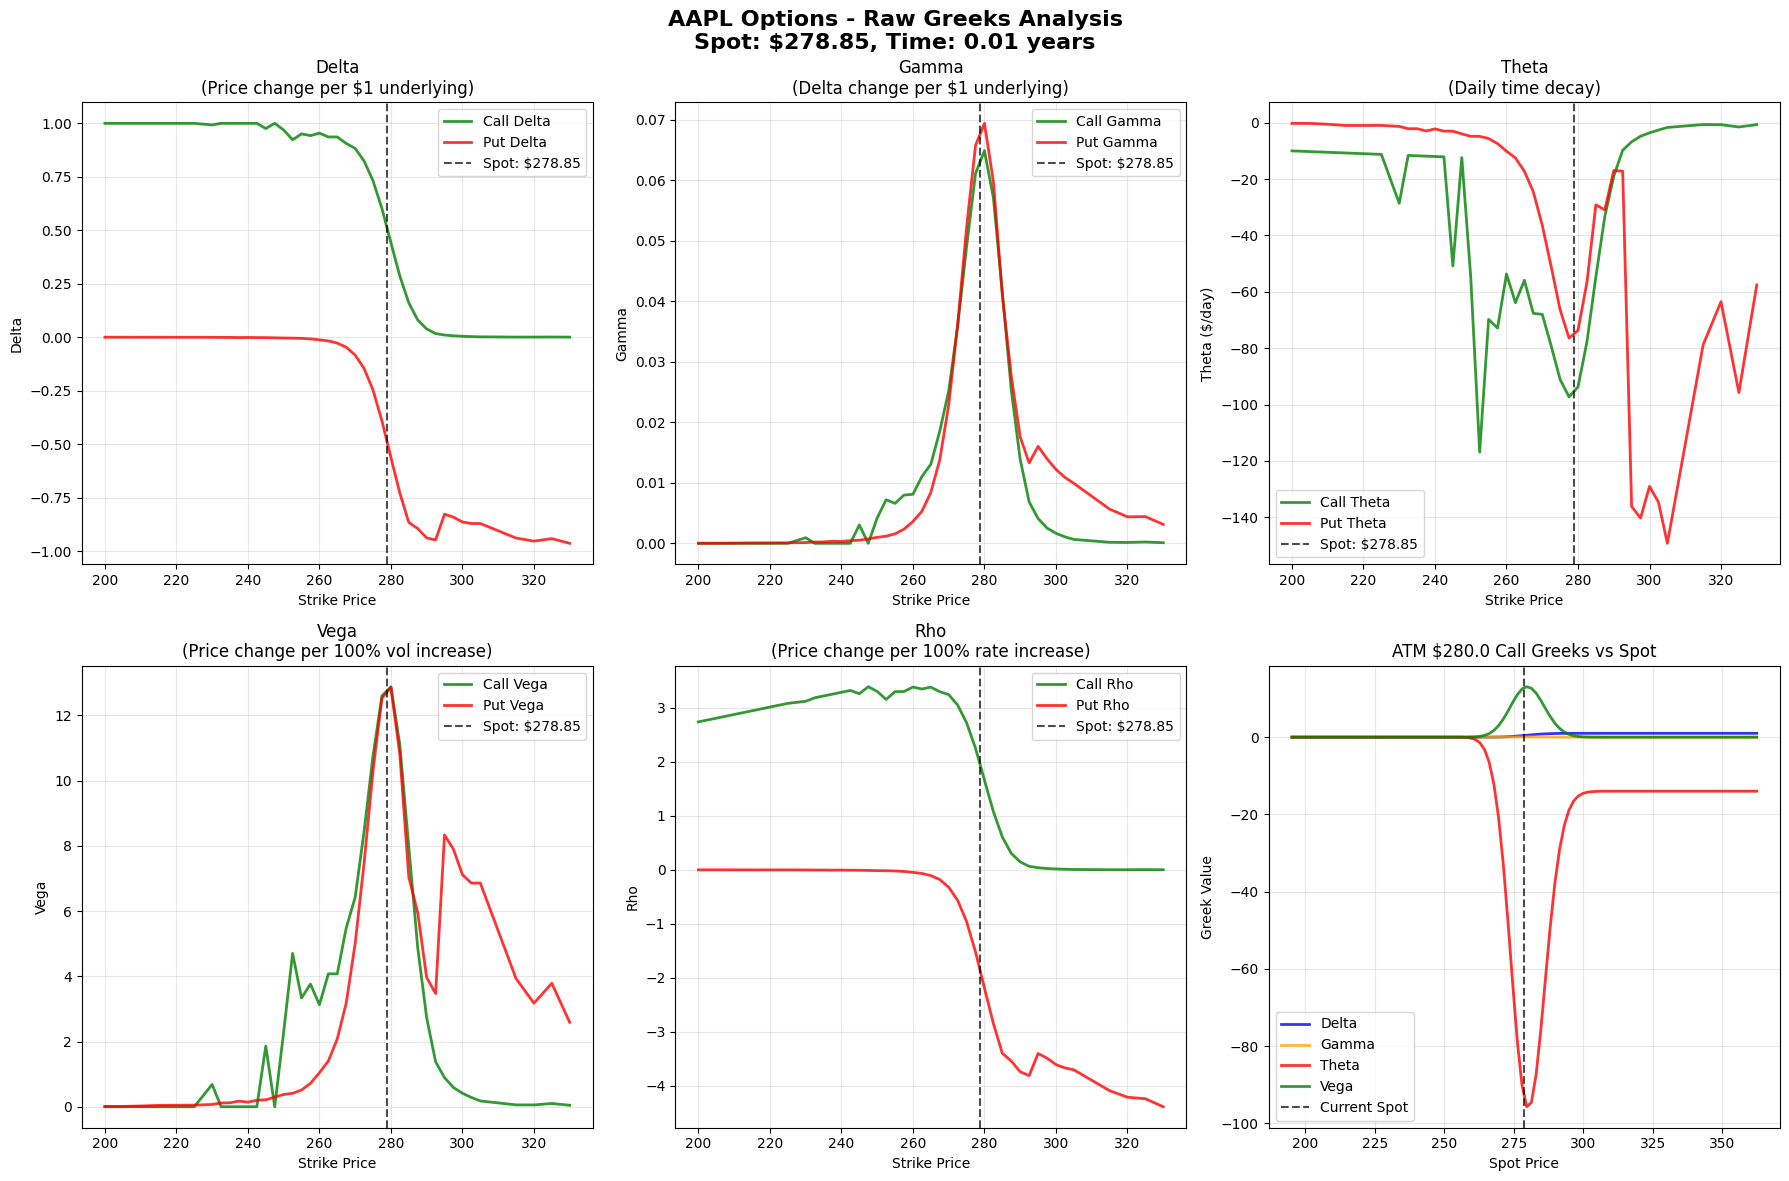


🎯 CURRENT ATM GREEKS - AAPL $280.0
Call: Delta=0.442, Gamma=0.0649, Theta=$-93.7067/day, Vega=12.8816, Rho=1.6606
Put:  Delta=-0.558, Gamma=0.0649, Theta=$-79.7163/day, Vega=12.8816, Rho=-2.1724


In [13]:
import numpy as np
import yfinance as yf
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt

def calculate_greeks_raw(K, r, t, s, sigma, option_type='call'):
    """
    Calculate all major Greeks for options - RAW VALUES
    Returns: delta, gamma, theta, vega, rho
    """
    if t <= 0 or sigma <= 0:
        if option_type == 'call':
            delta = 1.0 if s > K else 0.0
            return delta, 0.0, 0.0, 0.0, 0.0
        else:
            delta = -1.0 if s < K else 0.0
            return delta, 0.0, 0.0, 0.0, 0.0

    try:
        d1 = (np.log(s / K) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
        d2 = d1 - sigma * np.sqrt(t)
        pdf_d1 = norm.pdf(d1)

        # DELTA
        if option_type == 'call':
            delta = norm.cdf(d1)
        else:
            delta = norm.cdf(d1) - 1

        # GAMMA
        gamma = pdf_d1 / (s * sigma * np.sqrt(t))

        # THETA (per day)
        if option_type == 'call':
            theta = (-(s * pdf_d1 * sigma) / (2 * np.sqrt(t))
                     - r * K * np.exp(-r * t) * norm.cdf(d2))
        else:
            theta = (-(s * pdf_d1 * sigma) / (2 * np.sqrt(t))
                     + r * K * np.exp(-r * t) * norm.cdf(-d2))

        # VEGA
        vega = s * pdf_d1 * np.sqrt(t)

        # RHO
        if option_type == 'call':
            rho = K * t * np.exp(-r * t) * norm.cdf(d2)
        else:
            rho = -K * t * np.exp(-r * t) * norm.cdf(-d2)

        return delta, gamma, theta, vega, rho

    except:
        return 0.0, 0.0, 0.0, 0.0, 0.0

def BSM_options(ticker="AAPL", expiry=0, int_rate=0.05):
    stock = yf.Ticker(ticker)
    opt_chain = stock.option_chain(stock.options[expiry])

    calls = opt_chain.calls.copy()
    puts = opt_chain.puts.copy()

    S = stock.info['regularMarketPrice']
    expiration_date = datetime.strptime(stock.options[expiry], "%Y-%m-%d")
    today = datetime.now()
    T = (expiration_date - today).days / 365.0

    call_prices = []
    put_prices = []

    for i, row in calls.iterrows():
        K = row['strike']
        sigma = row['impliedVolatility']
        d1 = (np.log(S / K) + (int_rate + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        C = S * norm.cdf(d1) - K * np.exp(-int_rate * T) * norm.cdf(d2)
        call_prices.append(C)

    for i, row in puts.iterrows():
        K = row['strike']
        sigma = row['impliedVolatility']
        d1 = (np.log(S / K) + (int_rate + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        P = K * np.exp(-int_rate * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        put_prices.append(P)

    calls['BSM_theoretical'] = call_prices
    puts['BSM_theoretical'] = put_prices
    calls['BSM_vs_Market'] = calls['BSM_theoretical'] - calls['lastPrice']
    puts['BSM_vs_Market'] = puts['BSM_theoretical'] - puts['lastPrice']

    return {"calls": calls, "puts": puts}

def plot_all_greeks(ticker="AAPL", expiry=0):
    """
    Plot all Greeks in one comprehensive figure
    """
    results = BSM_options(ticker, expiry)
    calls_df = results['calls']
    puts_df = results['puts']

    stock = yf.Ticker(ticker)
    S = stock.info['regularMarketPrice']

    expiration_date = datetime.strptime(stock.options[expiry], "%Y-%m-%d")
    today = datetime.now()
    T = (expiration_date - today).days / 365.0
    r = 0.05

    # Get common strikes that exist in both calls and puts
    common_strikes = list(set(calls_df['strike']).intersection(set(puts_df['strike'])))
    common_strikes.sort()

    # Limit to reasonable range around spot price
    common_strikes = [K for K in common_strikes if S * 0.7 <= K <= S * 1.3]

    if not common_strikes:
        print("No common strikes found between calls and puts!")
        return

    print(f"📊 Analyzing {len(common_strikes)} common strikes")

    # Calculate Greeks for calls and puts
    call_deltas, call_gammas, call_thetas, call_vegas, call_rhos = [], [], [], [], []
    put_deltas, put_gammas, put_thetas, put_vegas, put_rhos = [], [], [], [], []

    for strike in common_strikes:
        try:
            # Get corresponding IV for this strike - safer method
            call_iv_data = calls_df[calls_df['strike'] == strike]['impliedVolatility']
            put_iv_data = puts_df[puts_df['strike'] == strike]['impliedVolatility']

            if len(call_iv_data) > 0 and len(put_iv_data) > 0:
                call_iv = call_iv_data.values[0]
                put_iv = put_iv_data.values[0]

                # Calculate call Greeks
                delta, gamma, theta, vega, rho = calculate_greeks_raw(strike, r, T, S, call_iv, 'call')
                call_deltas.append(delta)
                call_gammas.append(gamma)
                call_thetas.append(theta)
                call_vegas.append(vega)
                call_rhos.append(rho)

                # Calculate put Greeks
                delta, gamma, theta, vega, rho = calculate_greeks_raw(strike, r, T, S, put_iv, 'put')
                put_deltas.append(delta)
                put_gammas.append(gamma)
                put_thetas.append(theta)
                put_vegas.append(vega)
                put_rhos.append(rho)
            else:
                # Skip if data is missing
                continue

        except Exception as e:
            print(f"Error calculating Greeks for strike {strike}: {e}")
            continue

    # Create the plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{ticker} Options - Raw Greeks Analysis\nSpot: ${S:.2f}, Time: {T:.2f} years', fontsize=16, fontweight='bold')

    # Plot 1: DELTA
    axes[0,0].plot(common_strikes, call_deltas, 'g-', linewidth=2, label='Call Delta', alpha=0.8)
    axes[0,0].plot(common_strikes, put_deltas, 'r-', linewidth=2, label='Put Delta', alpha=0.8)
    axes[0,0].axvline(x=S, color='black', linestyle='--', alpha=0.7, label=f'Spot: ${S:.2f}')
    axes[0,0].set_xlabel('Strike Price')
    axes[0,0].set_ylabel('Delta')
    axes[0,0].set_title('Delta\n(Price change per $1 underlying)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Plot 2: GAMMA
    axes[0,1].plot(common_strikes, call_gammas, 'g-', linewidth=2, label='Call Gamma', alpha=0.8)
    axes[0,1].plot(common_strikes, put_gammas, 'r-', linewidth=2, label='Put Gamma', alpha=0.8)
    axes[0,1].axvline(x=S, color='black', linestyle='--', alpha=0.7, label=f'Spot: ${S:.2f}')
    axes[0,1].set_xlabel('Strike Price')
    axes[0,1].set_ylabel('Gamma')
    axes[0,1].set_title('Gamma\n(Delta change per $1 underlying)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Plot 3: THETA
    axes[0,2].plot(common_strikes, call_thetas, 'g-', linewidth=2, label='Call Theta', alpha=0.8)
    axes[0,2].plot(common_strikes, put_thetas, 'r-', linewidth=2, label='Put Theta', alpha=0.8)
    axes[0,2].axvline(x=S, color='black', linestyle='--', alpha=0.7, label=f'Spot: ${S:.2f}')
    axes[0,2].set_xlabel('Strike Price')
    axes[0,2].set_ylabel('Theta ($/day)')
    axes[0,2].set_title('Theta\n(Daily time decay)')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # Plot 4: VEGA
    axes[1,0].plot(common_strikes, call_vegas, 'g-', linewidth=2, label='Call Vega', alpha=0.8)
    axes[1,0].plot(common_strikes, put_vegas, 'r-', linewidth=2, label='Put Vega', alpha=0.8)
    axes[1,0].axvline(x=S, color='black', linestyle='--', alpha=0.7, label=f'Spot: ${S:.2f}')
    axes[1,0].set_xlabel('Strike Price')
    axes[1,0].set_ylabel('Vega')
    axes[1,0].set_title('Vega\n(Price change per 100% vol increase)')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Plot 5: RHO
    axes[1,1].plot(common_strikes, call_rhos, 'g-', linewidth=2, label='Call Rho', alpha=0.8)
    axes[1,1].plot(common_strikes, put_rhos, 'r-', linewidth=2, label='Put Rho', alpha=0.8)
    axes[1,1].axvline(x=S, color='black', linestyle='--', alpha=0.7, label=f'Spot: ${S:.2f}')
    axes[1,1].set_xlabel('Strike Price')
    axes[1,1].set_ylabel('Rho')
    axes[1,1].set_title('Rho\n(Price change per 100% rate increase)')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # Plot 6: Spot Sensitivity for ATM Option
    atm_strike = min(common_strikes, key=lambda x: abs(x - S))
    atm_call_data = calls_df[calls_df['strike'] == atm_strike]

    if len(atm_call_data) > 0:
        sigma_atm = atm_call_data['impliedVolatility'].values[0]

        s_range = np.linspace(S * 0.7, S * 1.3, 100)
        deltas_s, gammas_s, thetas_s, vegas_s = [], [], [], []

        for s_val in s_range:
            delta, gamma, theta, vega, _ = calculate_greeks_raw(atm_strike, r, T, s_val, sigma_atm, 'call')
            deltas_s.append(delta)
            gammas_s.append(gamma)
            thetas_s.append(theta)
            vegas_s.append(vega)

        axes[1,2].plot(s_range, deltas_s, 'b-', linewidth=2, label='Delta', alpha=0.8)
        axes[1,2].plot(s_range, gammas_s, 'orange', linewidth=2, label='Gamma', alpha=0.8)
        axes[1,2].plot(s_range, thetas_s, 'red', linewidth=2, label='Theta', alpha=0.8)
        axes[1,2].plot(s_range, vegas_s, 'green', linewidth=2, label='Vega', alpha=0.8)
        axes[1,2].axvline(x=S, color='black', linestyle='--', alpha=0.7, label='Current Spot')
        axes[1,2].set_xlabel('Spot Price')
        axes[1,2].set_ylabel('Greek Value')
        axes[1,2].set_title(f'ATM ${atm_strike} Call Greeks vs Spot')
        axes[1,2].legend()
        axes[1,2].grid(True, alpha=0.3)
    else:
        axes[1,2].text(0.5, 0.5, 'No ATM data available', ha='center', va='center', transform=axes[1,2].transAxes)
        axes[1,2].set_title('ATM Greeks vs Spot')

    plt.tight_layout()
    plt.show()

    # Print current ATM Greeks
    if len(atm_call_data) > 0:
        atm_call_greeks = calculate_greeks_raw(atm_strike, r, T, S, sigma_atm, 'call')
        atm_put_greeks = calculate_greeks_raw(atm_strike, r, T, S, sigma_atm, 'put')

        print(f"\n🎯 CURRENT ATM GREEKS - {ticker} ${atm_strike}")
        print(f"Call: Delta={atm_call_greeks[0]:.3f}, Gamma={atm_call_greeks[1]:.4f}, "
              f"Theta=${atm_call_greeks[2]:.4f}/day, Vega={atm_call_greeks[3]:.4f}, Rho={atm_call_greeks[4]:.4f}")
        print(f"Put:  Delta={atm_put_greeks[0]:.3f}, Gamma={atm_put_greeks[1]:.4f}, "
              f"Theta=${atm_put_greeks[2]:.4f}/day, Vega={atm_put_greeks[3]:.4f}, Rho={atm_put_greeks[4]:.4f}")

# Run the complete Greek analysis and plotting
plot_all_greeks("AAPL", 0)

In [ ]:
import yfinance as yf


stock = yf.Ticker("AAPL











































































































opt_chain = stock.option_chain(stock.options[0])

calls = opt_chain.calls.copy()
puts  = opt_chain.puts.copy()

In [ ]:
calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL251128C00110000,2025-11-26 19:51:56+00:00,110.0,168.25,0.0,0.0,2.029999,1.221272,1.0,0,0.000010,True,REGULAR,USD
1,AAPL251128C00120000,2025-11-05 17:41:07+00:00,120.0,150.80,0.0,0.0,0.000000,0.000000,NaN,0,0.000010,True,REGULAR,USD
2,AAPL251128C00125000,2025-11-26 17:55:06+00:00,125.0,153.85,0.0,0.0,8.080002,5.542980,4.0,0,0.000010,True,REGULAR,USD
3,AAPL251128C00130000,2025-11-06 15:22:28+00:00,130.0,141.01,0.0,0.0,0.000000,0.000000,NaN,0,0.000010,True,REGULAR,USD
4,AAPL251128C00135000,2025-11-26 15:29:49+00:00,135.0,142.25,0.0,0.0,-0.889999,-0.621768,2.0,0,0.000010,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,AAPL251128C00365000,2025-10-31 19:20:50+00:00,365.0,0.01,0.0,0.0,0.000000,0.000000,5.0,0,0.500005,False,REGULAR,USD
71,AAPL251128C00370000,2025-11-05 16:24:29+00:00,370.0,0.01,0.0,0.0,0.000000,0.000000,100.0,0,0.500005,False,REGULAR,USD
72,AAPL251128C00375000,2025-11-05 14:34:46+00:00,375.0,0.01,0.0,0.0,0.000000,0.000000,3.0,0,0.500005,False,REGULAR,USD
73,AAPL251128C00395000,2025-11-07 20:25:10+00:00,395.0,0.01,0.0,0.0,0.000000,0.000000,1.0,0,0.500005,False,REGULAR,USD


In [ ]:
stock

yfinance.Ticker object <AAPL>